<a href="https://colab.research.google.com/github/deema1999/AI-Gym-Tracker-Mediapip-and-Python/blob/main/semantic_seg_unet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start : import python packages

In [1]:
## import some important packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import glob
from tqdm import tqdm_notebook, tqdm
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array,load_img

from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.python.keras.metrics import Metric
import tensorflow as tf

from skimage.io import imread, imshow, concatenate_images
from PIL import Image
import cv2

from albumentations import RandomCrop, HorizontalFlip, VerticalFlip
from sklearn.model_selection import train_test_split

import os


# Connect to Google Drive to access the dataset (images & masks)


jotting down the path to the dataset !

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
path = "/gdrive/MyDrive/unet_seg/dataset_dir/"

# Prepare the dataset


okay so in the above path, we have images and their corresponding labels / masks as well

In [4]:
images_path = glob.glob(os.path.join(path, "images/*"))
labels_path = glob.glob(os.path.join(path, "masks/*"))

Are they sorted ? Let's print a few and notice the image titles !!!

In [5]:
for i in range(len(images_path)):
    print(images_path[i])
    print(labels_path[i])

/gdrive/MyDrive/unet_seg/train_dir/images/414.jpg
/gdrive/MyDrive/unet_seg/train_dir/masks/201.png
/gdrive/MyDrive/unet_seg/train_dir/images/571.jpg
/gdrive/MyDrive/unet_seg/train_dir/masks/704.png
/gdrive/MyDrive/unet_seg/train_dir/images/384.jpg
/gdrive/MyDrive/unet_seg/train_dir/masks/17.png
/gdrive/MyDrive/unet_seg/train_dir/images/435.jpg
/gdrive/MyDrive/unet_seg/train_dir/masks/495.png
/gdrive/MyDrive/unet_seg/train_dir/images/285.jpg
/gdrive/MyDrive/unet_seg/train_dir/masks/731.png
/gdrive/MyDrive/unet_seg/train_dir/images/766.jpg
/gdrive/MyDrive/unet_seg/train_dir/masks/221.png
/gdrive/MyDrive/unet_seg/train_dir/images/344.jpg
/gdrive/MyDrive/unet_seg/train_dir/masks/895.png
/gdrive/MyDrive/unet_seg/train_dir/images/661.jpg
/gdrive/MyDrive/unet_seg/train_dir/masks/716.png
/gdrive/MyDrive/unet_seg/train_dir/images/704.jpg
/gdrive/MyDrive/unet_seg/train_dir/masks/692.png
/gdrive/MyDrive/unet_seg/train_dir/images/694.jpg
/gdrive/MyDrive/unet_seg/train_dir/masks/491.png
/gdrive/MyD

No they are not, so lets sort them first thing !

In [6]:
images_path = sorted(images_path)
labels_path = sorted(labels_path)

Data augmentation !!!
Simply resizing all the images and the corresponding masks

In [7]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [8]:

def augment_data(images, masks, save_path, augment=False):
    W = 1280
    H = 720
    for x,y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]       
        
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = cv2.resize(x, (W, H))
        y = cv2.imread(y, cv2.IMREAD_COLOR)
        y = cv2.resize(y, (W, H))
        
        if augment == True:
            
            aug = RandomCrop(int(2*H/3), int(2*W/3), always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]
 
            aug = HorizontalFlip(always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]
            
            aug = VerticalFlip(always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"] 
            
            save_images = [x, x1, x2, x3]
            save_masks = [y, y1, y2, y3]            
          
        else:
            save_images = [x]
            save_masks = [y]
        
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))
            
            tmp_img_name = f"{image_name}_{idx}.{image_extn}"
            tmp_msk_name = f"{mask_name}_{idx}.{mask_extn}" 
            
            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_msk_name)
            
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx+=1

In [9]:
save_path = "./new_data/"

create_dir("./new_data/images/")
create_dir("./new_data/masks/")

to_augment = True

augment_data(images_path, labels_path, save_path, augment=to_augment)


100%|██████████| 920/920 [13:42<00:00,  1.12it/s]


In [10]:
images_path = sorted(glob.glob(os.path.join(save_path, "images/*")))
labels_path = sorted(glob.glob(os.path.join(save_path, "masks/*")))
print(f"Augmented images:  {len(images_path)} - Augmented masks: {len(labels_path)}")

Augmented images:  3680 - Augmented masks: 3680


Let's look at some images and their corresponding masks !

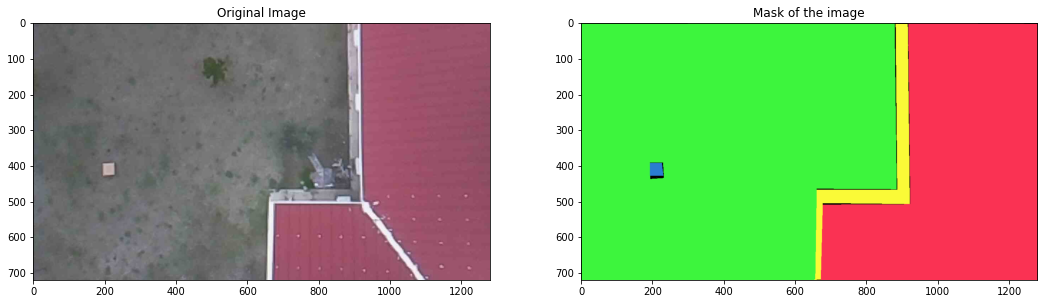

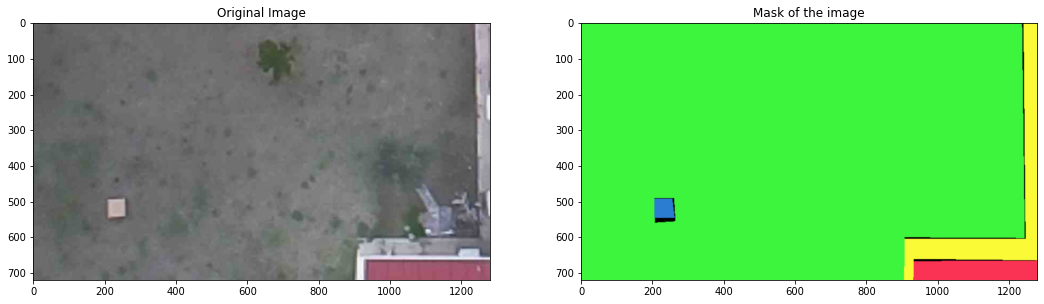

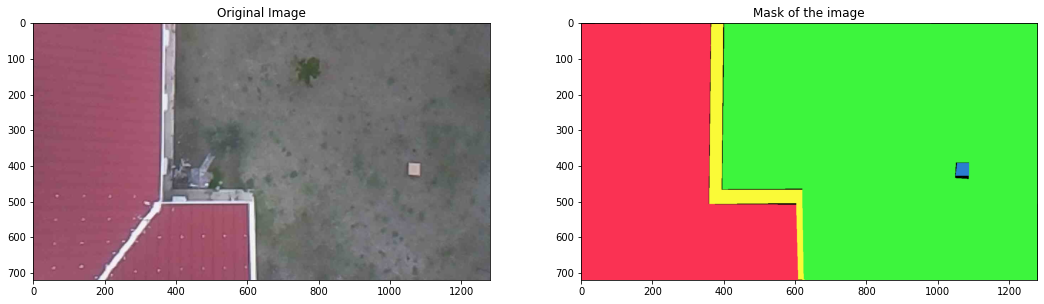

In [11]:
for i in range(0, 3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 12))
    aerial_img = imread(images_path[i])
    #print(aerial_img.shape)
    ax1.imshow(aerial_img)
    ax1.set_title('Original Image')
    
    aerial_mask = imread(labels_path[i])
    ax2.imshow(aerial_mask)
    ax2.set_title('Mask of the image')


In [12]:
image_path =  os.path.join(save_path, "images/")
label_path = os.path.join(save_path, "masks/")

name = list()

for dirname, _, filenames in os.walk(image_path):
    for filename in filenames:
        #print(dirname)
        #print(filename)
        name.append(filename.split('.')[0])
        
df_images = pd.DataFrame({'id': name}, index = np.arange(0, len(name)))
df_labels = pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [13]:
print(df_images.head())
print(df_labels.head())

      id
0  207_2
1  923_0
2  437_3
3  336_1
4  892_0
      id
0  207_2
1  923_0
2  437_3
3  336_1
4  892_0


In [14]:
Xtrainval, Xtest = train_test_split(df_images['id'], test_size = 0.2, random_state = 19)

print(f"Train Size: {len(Xtrainval)} images")
print(f"Test Size: {len(Xtest)} images")

Xtrain, Xval = train_test_split(Xtrainval, test_size=0.2, random_state=19)

print(f"Val Size: {len(Xval)} images")

Train Size: 2944 images
Test Size: 736 images
Val Size: 589 images


In [15]:
Ytrain = Xtrain
Ytest = Xtest
Yval = Xval

In [16]:
img_train = [os.path.join(save_path, "images/", f"{name}.jpg") for name in Xtrain]
mask_train = [os.path.join(save_path, "masks/", f"{name}.png") for name in Ytrain]

img_test = [os.path.join(save_path, "images/", f"{name}.jpg") for name in Xtest]
mask_test = [os.path.join(save_path, "masks/", f"{name}.png") for name in Ytest]

img_val = [os.path.join(save_path, "images/", f"{name}.jpg") for name in Xval]
mask_val = [os.path.join(save_path, "masks/", f"{name}.png") for name in Yval]

In [86]:
print(len(img_train))
print(len(img_test))
print(len(img_val))

Train Size: 2355
Test Size: 736
Validation Size: 589


# Build Unet Model


In [18]:
def conv_block(inputs, filter_count, pool=True, batchnorm = True):
    
    #first layer
    x = Conv2D(filter_count, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #second layer
    x = Conv2D(filter_count, 3, padding = 'same', kernel_initializer = 'he_normal')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x


In [19]:
def deconv_block(inputs, concat_layer, filter_count, pool = False):
    u = UpSampling2D((2,2), interpolation='bilinear')(inputs)
    c = Concatenate()([u, concat_layer])
    x = conv_block(c, filter_count, pool = pool, batchnorm = True)
    return u, c, x

In [20]:
def make_me_a_unet(shape, num_classes):
    
    inputs = Input(shape) # 768 x 1152
    
    # Downsampling side of the UNET i.e. the encoder !
    
    x1, p1 = conv_block(inputs, 32, pool=True, batchnorm=True)
    x2, p2 = conv_block(p1, 64, pool=True, batchnorm=True)
    x3, p3 = conv_block(p2, 96, pool=True, batchnorm=True)
    x4, p4 = conv_block(p3, 128, pool=True, batchnorm=True)
    b = conv_block(p4, 256, pool=False, batchnorm=True)
    
    # Upsampling side of the UNET i.e the decoder !
    
    u1, c1, x5 = deconv_block(b, x4, 128)
    u2, c2, x6 = deconv_block(x5, x3, 96)
    u3, c3, x7 = deconv_block(x6, x2, 64)
    u4, c4, x8 = deconv_block(x7, x1, 32)
    
    # The output layer
    
    output = Conv2D(9, 1, padding='same', activation='softmax')(x8)
    
    #softmax for multiclass classification, num_classes = 23 !
    
    return Model(inputs, output)

In [21]:
#Setting some parameters

H = 768 
W = int(H*(3/2)) 
num_classes = 9

In [22]:
model = make_me_a_unet((W, H, 3), num_classes)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1152, 768,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 1152, 768, 3  896         ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1152, 768, 3  128        ['conv2d[0][0]']                 
 alization)                     2)                                                            

In [24]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

In [25]:
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

In [26]:
def tf_dataset(x,y, batch=1):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

In [27]:
def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, num_classes])
    return image, mask

In [38]:
# Seeding
np.random.seed(42)
tf.random.set_seed(42)
                 
shape = (H, W, 3) 

# Hyperparameters
lr = 0.001 # Learning rate of Adam optimizer
batch_size = 4
epochs = 30

# Train and Save our Unet model


In [39]:
# Model
model = make_me_a_unet(shape, num_classes)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

callbacks = [
    ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.1, verbose=1, min_lr=1e-1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1)
]

## Train the model
model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=epochs,
          callbacks=callbacks
         )

Epoch 1/30
588/588 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.5664
Epoch 1: saving model to model.h5
588/588 [==============================] - 359s 608ms/step - loss: 0.0082 - accuracy: 0.5664 - val_loss: 0.0066 - val_accuracy: 0.1024 - lr: 0.0010
Epoch 2/30
588/588 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.5582
Epoch 2: saving model to model.h5
588/588 [==============================] - 361s 608ms/step - loss: 0.0078 - accuracy: 0.5582 - val_loss: 0.0062 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 3/30
588/588 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.5719
Epoch 3: saving model to model.h5
588/588 [==============================] - 357s 607ms/step - loss: 0.0071 - accuracy: 0.5719 - val_loss: 0.0061 - val_accuracy: 0.5615 - lr: 0.0010
Epoch 4/30
588/588 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.6097
Epoch 4: saving model to model.h5
588/588 [===========================

In [87]:
model.save('model.h5')

# Results

In [40]:
## Plot accuracy and loss

train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['accuracy']
val_acc    = model.history.history['val_accuracy']

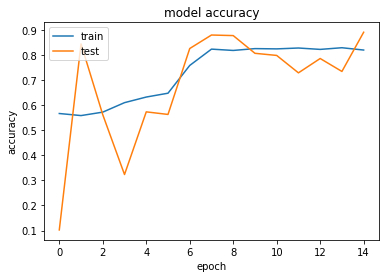

In [41]:
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

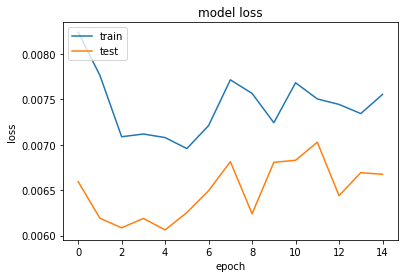

In [42]:
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
## Prediction

os.makedirs('./results')
np.random.seed(42)
tf.random.set_seed(42)


In [44]:
# Saving the masks
for x, y in tqdm(zip(img_test, mask_test), total=len(img_test)):
    name = x.split("/")[-1]
    
    ## Read image
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)

    ## Read mask
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))
    
    y = np.expand_dims(y, axis=-1) 
    
    y = y * (255/num_classes)
    y = y.astype(np.int32)
    y = np.concatenate([y, y, y], axis=2)
    
    ## Prediction
    p = model.predict(np.expand_dims(x, axis=0))[0]
    p = np.argmax(p, axis=-1)
    
    p = np.expand_dims(p, axis=-1)  
    
    p = p * (255/num_classes)
    p = p.astype(np.int32)
    p = np.concatenate([p, p, p], axis=2)
      
    cv2.imwrite(f"./results/{name}", p)

  0%|          | 0/736 [00:00<?, ?it/s]

1/1 [==============================] - 1s 857ms/step


  0%|          | 1/736 [00:00<11:57,  1.02it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 2/736 [00:01<06:05,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 3/736 [00:01<04:11,  2.92it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 4/736 [00:01<03:17,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 5/736 [00:01<02:47,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 6/736 [00:01<02:29,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 7/736 [00:01<02:19,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 8/736 [00:02<02:11,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 9/736 [00:02<02:06,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 10/736 [00:02<02:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 11/736 [00:02<02:00,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 12/736 [00:02<02:00,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 13/736 [00:02<01:59,  6.06it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 14/736 [00:03<01:58,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 15/736 [00:03<01:57,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 16/736 [00:03<01:57,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 17/736 [00:03<01:56,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 18/736 [00:03<01:56,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 19/736 [00:03<01:57,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 20/736 [00:04<01:56,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 21/736 [00:04<01:56,  6.15it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 22/736 [00:04<01:56,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 23/736 [00:04<01:58,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 24/736 [00:04<01:58,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 25/736 [00:04<01:57,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 26/736 [00:05<01:57,  6.04it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 27/736 [00:05<01:57,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 28/736 [00:05<01:57,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 29/736 [00:05<01:56,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 30/736 [00:05<01:56,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 31/736 [00:05<01:55,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 32/736 [00:06<01:55,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 33/736 [00:06<01:58,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 34/736 [00:06<01:59,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 35/736 [00:06<01:59,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 36/736 [00:06<01:59,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 37/736 [00:06<01:59,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 38/736 [00:07<01:58,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 39/736 [00:07<01:58,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 40/736 [00:07<01:57,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 41/736 [00:07<01:57,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 42/736 [00:07<01:56,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 43/736 [00:07<01:58,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 44/736 [00:08<01:59,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 45/736 [00:08<01:57,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 46/736 [00:08<01:56,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 47/736 [00:08<01:55,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 48/736 [00:08<01:54,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 49/736 [00:08<01:53,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 50/736 [00:09<01:53,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 51/736 [00:09<01:52,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 52/736 [00:09<01:52,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 53/736 [00:09<01:52,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 54/736 [00:09<01:53,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 55/736 [00:09<01:53,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 56/736 [00:10<01:52,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 57/736 [00:10<01:52,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 58/736 [00:10<01:52,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 59/736 [00:10<01:52,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 60/736 [00:10<01:52,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 61/736 [00:10<01:51,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 62/736 [00:11<01:51,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 63/736 [00:11<01:51,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 64/736 [00:11<01:52,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 65/736 [00:11<01:51,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 66/736 [00:11<01:51,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 67/736 [00:11<01:50,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 68/736 [00:12<01:50,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 69/736 [00:12<01:49,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 70/736 [00:12<01:48,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 71/736 [00:12<01:49,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 72/736 [00:12<01:48,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 73/736 [00:12<01:48,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 74/736 [00:13<01:49,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 75/736 [00:13<01:49,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 76/736 [00:13<01:48,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 77/736 [00:13<01:48,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 78/736 [00:13<01:48,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 79/736 [00:13<01:48,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 80/736 [00:14<01:48,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 81/736 [00:14<01:47,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 82/736 [00:14<01:48,  6.05it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 83/736 [00:14<01:49,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 84/736 [00:14<01:50,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 85/736 [00:14<01:51,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 86/736 [00:15<01:51,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 87/736 [00:15<01:51,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 88/736 [00:15<01:51,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 89/736 [00:15<01:49,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 90/736 [00:15<01:48,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 91/736 [00:15<01:47,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 92/736 [00:16<01:46,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 93/736 [00:16<01:45,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 94/736 [00:16<01:45,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 95/736 [00:16<01:46,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 96/736 [00:16<01:45,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 97/736 [00:16<01:46,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 98/736 [00:17<01:45,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 99/736 [00:17<01:45,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 100/736 [00:17<01:44,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 101/736 [00:17<01:44,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 102/736 [00:17<01:44,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 103/736 [00:17<01:43,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 104/736 [00:18<01:43,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 105/736 [00:18<01:44,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 106/736 [00:18<01:44,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 107/736 [00:18<01:44,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 108/736 [00:18<01:44,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 109/736 [00:18<01:43,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 110/736 [00:19<01:43,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 111/736 [00:19<01:42,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 112/736 [00:19<01:42,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 113/736 [00:19<01:42,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 114/736 [00:19<01:42,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 115/736 [00:19<01:41,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 116/736 [00:20<01:42,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 117/736 [00:20<01:43,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 118/736 [00:20<01:43,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 119/736 [00:20<01:42,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 120/736 [00:20<01:41,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 121/736 [00:20<01:40,  6.11it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 122/736 [00:20<01:40,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 123/736 [00:21<01:40,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 124/736 [00:21<01:39,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 125/736 [00:21<01:39,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 126/736 [00:21<01:40,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 127/736 [00:21<01:40,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 128/736 [00:21<01:40,  6.03it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 129/736 [00:22<01:41,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 130/736 [00:22<01:40,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 131/736 [00:22<01:39,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 132/736 [00:22<01:38,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 133/736 [00:22<01:38,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 134/736 [00:22<01:38,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 135/736 [00:23<01:38,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 136/736 [00:23<01:38,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 137/736 [00:23<01:38,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 138/736 [00:23<01:37,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 139/736 [00:23<01:37,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 140/736 [00:23<01:37,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 141/736 [00:24<01:37,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 142/736 [00:24<01:36,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 143/736 [00:24<01:36,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 144/736 [00:24<01:35,  6.17it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 145/736 [00:24<01:35,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 146/736 [00:24<01:35,  6.19it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 147/736 [00:25<01:35,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 148/736 [00:25<01:35,  6.14it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 149/736 [00:25<01:36,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 150/736 [00:25<01:35,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 151/736 [00:25<01:36,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 152/736 [00:25<01:35,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 153/736 [00:26<01:35,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 154/736 [00:26<01:34,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 155/736 [00:26<01:33,  6.20it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 156/736 [00:26<01:34,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 157/736 [00:26<01:35,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 158/736 [00:26<01:35,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 159/736 [00:27<01:35,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 160/736 [00:27<01:35,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 161/736 [00:27<01:34,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 162/736 [00:27<01:34,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 163/736 [00:27<01:33,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 164/736 [00:27<01:33,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 165/736 [00:28<01:33,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 166/736 [00:28<01:33,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 167/736 [00:28<01:33,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 168/736 [00:28<01:33,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 169/736 [00:28<01:32,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 170/736 [00:28<01:33,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 171/736 [00:29<01:32,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 172/736 [00:29<01:32,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 173/736 [00:29<01:32,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 174/736 [00:29<01:31,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 175/736 [00:29<01:31,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 176/736 [00:29<01:30,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 177/736 [00:30<01:32,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 178/736 [00:30<01:31,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 179/736 [00:30<01:31,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 180/736 [00:30<01:31,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 181/736 [00:30<01:30,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 182/736 [00:30<01:30,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 183/736 [00:30<01:30,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 184/736 [00:31<01:30,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 185/736 [00:31<01:30,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 186/736 [00:31<01:30,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 187/736 [00:31<01:30,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 188/736 [00:31<01:30,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 189/736 [00:31<01:30,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 190/736 [00:32<01:30,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 191/736 [00:32<01:29,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 192/736 [00:32<01:29,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 193/736 [00:32<01:28,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 194/736 [00:32<01:28,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 195/736 [00:32<01:28,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 196/736 [00:33<01:28,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 197/736 [00:33<01:27,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 198/736 [00:33<01:28,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 199/736 [00:33<01:28,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 200/736 [00:33<01:28,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 201/736 [00:33<01:27,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 202/736 [00:34<01:27,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 203/736 [00:34<01:27,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 204/736 [00:34<01:27,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 205/736 [00:34<01:26,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 206/736 [00:34<01:26,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 207/736 [00:34<01:26,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 208/736 [00:35<01:27,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 209/736 [00:35<01:26,  6.08it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 210/736 [00:35<01:26,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 211/736 [00:35<01:26,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 212/736 [00:35<01:26,  6.06it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 213/736 [00:35<01:26,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 214/736 [00:36<01:25,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 215/736 [00:36<01:25,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 216/736 [00:36<01:25,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 217/736 [00:36<01:25,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 218/736 [00:36<01:26,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 219/736 [00:36<01:26,  5.97it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 220/736 [00:37<01:27,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 221/736 [00:37<01:27,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 222/736 [00:37<01:27,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 223/736 [00:37<01:26,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 224/736 [00:37<01:25,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 225/736 [00:37<01:25,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 226/736 [00:38<01:24,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 227/736 [00:38<01:24,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 228/736 [00:38<01:23,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 229/736 [00:38<01:24,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 230/736 [00:38<01:23,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 231/736 [00:38<01:22,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 232/736 [00:39<01:22,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 233/736 [00:39<01:22,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 234/736 [00:39<01:22,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 235/736 [00:39<01:21,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 236/736 [00:39<01:21,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 237/736 [00:39<01:21,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 238/736 [00:40<01:21,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 239/736 [00:40<01:22,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 240/736 [00:40<01:21,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 241/736 [00:40<01:21,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 242/736 [00:40<01:20,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 243/736 [00:40<01:20,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 244/736 [00:41<01:20,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 245/736 [00:41<01:20,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 246/736 [00:41<01:19,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 247/736 [00:41<01:19,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 248/736 [00:41<01:19,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 249/736 [00:41<01:20,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 250/736 [00:42<01:19,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 251/736 [00:42<01:19,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 252/736 [00:42<01:19,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 253/736 [00:42<01:18,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 254/736 [00:42<01:18,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 255/736 [00:42<01:17,  6.17it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 256/736 [00:42<01:17,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 257/736 [00:43<01:17,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 258/736 [00:43<01:17,  6.20it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 259/736 [00:43<01:17,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 260/736 [00:43<01:18,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 261/736 [00:43<01:18,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 262/736 [00:43<01:17,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 263/736 [00:44<01:17,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 264/736 [00:44<01:16,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 265/736 [00:44<01:16,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 266/736 [00:44<01:16,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 267/736 [00:44<01:16,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 268/736 [00:44<01:15,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 269/736 [00:45<01:15,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 270/736 [00:45<01:16,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 271/736 [00:45<01:16,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 272/736 [00:45<01:15,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 273/736 [00:45<01:14,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 274/736 [00:45<01:14,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 275/736 [00:46<01:14,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 276/736 [00:46<01:14,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 277/736 [00:46<01:14,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 278/736 [00:46<01:14,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 279/736 [00:46<01:14,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 280/736 [00:46<01:16,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 281/736 [00:47<01:15,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 282/736 [00:47<01:14,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 283/736 [00:47<01:14,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 284/736 [00:47<01:14,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 285/736 [00:47<01:13,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 286/736 [00:47<01:13,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 287/736 [00:48<01:13,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 288/736 [00:48<01:13,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 289/736 [00:48<01:12,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 290/736 [00:48<01:12,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 291/736 [00:48<01:13,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 292/736 [00:48<01:12,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 293/736 [00:49<01:12,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 294/736 [00:49<01:12,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 295/736 [00:49<01:11,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 296/736 [00:49<01:11,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 297/736 [00:49<01:11,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 298/736 [00:49<01:11,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 299/736 [00:50<01:11,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 300/736 [00:50<01:11,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 301/736 [00:50<01:12,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 302/736 [00:50<01:11,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 303/736 [00:50<01:10,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 304/736 [00:50<01:10,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 305/736 [00:50<01:10,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 306/736 [00:51<01:10,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 307/736 [00:51<01:10,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 308/736 [00:51<01:10,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 309/736 [00:51<01:10,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 310/736 [00:51<01:09,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 311/736 [00:51<01:10,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 312/736 [00:52<01:10,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 313/736 [00:52<01:09,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 314/736 [00:52<01:09,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 315/736 [00:52<01:08,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 316/736 [00:52<01:08,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 317/736 [00:52<01:08,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 318/736 [00:53<01:08,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 319/736 [00:53<01:07,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 320/736 [00:53<01:07,  6.15it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 321/736 [00:53<01:08,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 322/736 [00:53<01:08,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 323/736 [00:53<01:08,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 324/736 [00:54<01:07,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 325/736 [00:54<01:07,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 326/736 [00:54<01:07,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 327/736 [00:54<01:06,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 328/736 [00:54<01:06,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 329/736 [00:54<01:06,  6.13it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 330/736 [00:55<01:06,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 331/736 [00:55<01:06,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 332/736 [00:55<01:07,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 333/736 [00:55<01:06,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 334/736 [00:55<01:05,  6.11it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 335/736 [00:55<01:05,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 336/736 [00:56<01:05,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 337/736 [00:56<01:04,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 338/736 [00:56<01:04,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 339/736 [00:56<01:04,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 340/736 [00:56<01:04,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 341/736 [00:56<01:04,  6.10it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 342/736 [00:57<01:05,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 343/736 [00:57<01:04,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 344/736 [00:57<01:04,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 345/736 [00:57<01:04,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 346/736 [00:57<01:04,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 347/736 [00:57<01:03,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 348/736 [00:58<01:04,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 349/736 [00:58<01:03,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 350/736 [00:58<01:03,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 351/736 [00:58<01:02,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 352/736 [00:58<01:03,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 353/736 [00:58<01:02,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 354/736 [00:59<01:02,  6.12it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 355/736 [00:59<01:03,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 356/736 [00:59<01:02,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 357/736 [00:59<01:01,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 358/736 [00:59<01:01,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 359/736 [00:59<01:01,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 360/736 [01:00<01:00,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 361/736 [01:00<01:00,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 362/736 [01:00<01:00,  6.19it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 363/736 [01:00<01:00,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 364/736 [01:00<01:00,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 365/736 [01:00<01:00,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 366/736 [01:00<01:00,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 367/736 [01:01<01:00,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 368/736 [01:01<00:59,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 369/736 [01:01<00:59,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 370/736 [01:01<00:59,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 371/736 [01:01<00:59,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 372/736 [01:01<00:58,  6.17it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 373/736 [01:02<00:59,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 374/736 [01:02<00:59,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 375/736 [01:02<00:58,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 376/736 [01:02<00:58,  6.17it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 377/736 [01:02<00:58,  6.16it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 378/736 [01:02<00:59,  6.05it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 379/736 [01:03<00:59,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 380/736 [01:03<00:59,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 381/736 [01:03<00:59,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 382/736 [01:03<00:58,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 383/736 [01:03<00:59,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 384/736 [01:03<01:00,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 385/736 [01:04<01:00,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 386/736 [01:04<01:00,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 387/736 [01:04<00:59,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 388/736 [01:04<00:58,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 389/736 [01:04<00:58,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 390/736 [01:04<00:58,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 391/736 [01:05<00:58,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 392/736 [01:05<00:57,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 393/736 [01:05<00:56,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 394/736 [01:05<00:56,  6.02it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 395/736 [01:05<00:56,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 396/736 [01:05<00:56,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 397/736 [01:06<00:55,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 398/736 [01:06<00:55,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 399/736 [01:06<00:55,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 400/736 [01:06<00:54,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 401/736 [01:06<00:54,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 402/736 [01:06<00:54,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 403/736 [01:07<00:54,  6.15it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 404/736 [01:07<00:54,  6.08it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 405/736 [01:07<00:55,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 406/736 [01:07<00:55,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 407/736 [01:07<00:55,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 408/736 [01:07<00:55,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 409/736 [01:08<00:55,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 410/736 [01:08<00:54,  5.97it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 411/736 [01:08<00:54,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 412/736 [01:08<00:54,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 413/736 [01:08<00:53,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 414/736 [01:08<00:54,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 415/736 [01:09<00:54,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 416/736 [01:09<00:53,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 417/736 [01:09<00:52,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 418/736 [01:09<00:52,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 419/736 [01:09<00:51,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 420/736 [01:09<00:51,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 421/736 [01:10<00:51,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 422/736 [01:10<00:51,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 423/736 [01:10<00:51,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 424/736 [01:10<00:51,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 425/736 [01:10<00:51,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 426/736 [01:10<00:50,  6.09it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 427/736 [01:11<00:50,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 428/736 [01:11<00:50,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 429/736 [01:11<00:49,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 430/736 [01:11<00:49,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 431/736 [01:11<00:49,  6.15it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 432/736 [01:11<00:50,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 433/736 [01:12<00:49,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 434/736 [01:12<00:49,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 435/736 [01:12<00:49,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 436/736 [01:12<00:49,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 437/736 [01:12<00:48,  6.11it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 438/736 [01:12<00:48,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 439/736 [01:13<00:48,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 440/736 [01:13<00:48,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 441/736 [01:13<00:47,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 442/736 [01:13<00:47,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 443/736 [01:13<00:47,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 444/736 [01:13<00:47,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 445/736 [01:14<00:48,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 446/736 [01:14<00:47,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 447/736 [01:14<00:47,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 448/736 [01:14<00:47,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 449/736 [01:14<00:46,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 450/736 [01:14<00:46,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 451/736 [01:15<00:46,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 452/736 [01:15<00:45,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 453/736 [01:15<00:46,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 454/736 [01:15<00:46,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 455/736 [01:15<00:46,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 456/736 [01:15<00:46,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 457/736 [01:16<00:45,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 458/736 [01:16<00:45,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 459/736 [01:16<00:45,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▎   | 460/736 [01:16<00:45,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 461/736 [01:16<00:44,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 462/736 [01:16<00:44,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 463/736 [01:16<00:44,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 464/736 [01:17<00:43,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 465/736 [01:17<00:44,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 466/736 [01:17<00:44,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 467/736 [01:17<00:43,  6.14it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 468/736 [01:17<00:43,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 469/736 [01:17<00:43,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 470/736 [01:18<00:43,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 471/736 [01:18<00:43,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 472/736 [01:18<00:43,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 473/736 [01:18<00:42,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 474/736 [01:18<00:42,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 475/736 [01:18<00:42,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 476/736 [01:19<00:42,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 477/736 [01:19<00:42,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 478/736 [01:19<00:42,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 479/736 [01:19<00:41,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 480/736 [01:19<00:41,  6.17it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 481/736 [01:19<00:41,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 482/736 [01:20<00:41,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 483/736 [01:20<00:41,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 484/736 [01:20<00:40,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 485/736 [01:20<00:40,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 486/736 [01:20<00:41,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 487/736 [01:20<00:40,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 488/736 [01:21<00:40,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 489/736 [01:21<00:40,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 490/736 [01:21<00:39,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 491/736 [01:21<00:39,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 492/736 [01:21<00:39,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 493/736 [01:21<00:39,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 494/736 [01:22<00:39,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 495/736 [01:22<00:39,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 496/736 [01:22<00:39,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 497/736 [01:22<00:39,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 498/736 [01:22<00:38,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 499/736 [01:22<00:38,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 500/736 [01:23<00:38,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 501/736 [01:23<00:38,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 502/736 [01:23<00:38,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 503/736 [01:23<00:37,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 504/736 [01:23<00:37,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 505/736 [01:23<00:37,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 506/736 [01:23<00:37,  6.17it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 507/736 [01:24<00:37,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 508/736 [01:24<00:37,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 509/736 [01:24<00:37,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 510/736 [01:24<00:36,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 511/736 [01:24<00:36,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 512/736 [01:24<00:36,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 513/736 [01:25<00:36,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 514/736 [01:25<00:36,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 515/736 [01:25<00:35,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 516/736 [01:25<00:35,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 517/736 [01:25<00:36,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 518/736 [01:25<00:35,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 519/736 [01:26<00:35,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 520/736 [01:26<00:35,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 521/736 [01:26<00:35,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 522/736 [01:26<00:34,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 523/736 [01:26<00:34,  6.17it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 524/736 [01:26<00:34,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 525/736 [01:27<00:34,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 526/736 [01:27<00:34,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 527/736 [01:27<00:34,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 528/736 [01:27<00:33,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 529/736 [01:27<00:33,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 530/736 [01:27<00:33,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 531/736 [01:28<00:33,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 532/736 [01:28<00:33,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 533/736 [01:28<00:32,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 534/736 [01:28<00:32,  6.20it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 535/736 [01:28<00:32,  6.21it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 536/736 [01:28<00:32,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 537/736 [01:29<00:32,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 538/736 [01:29<00:32,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 539/736 [01:29<00:32,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 540/736 [01:29<00:31,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 541/736 [01:29<00:31,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 542/736 [01:29<00:31,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 543/736 [01:30<00:31,  6.17it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 544/736 [01:30<00:31,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 545/736 [01:30<00:31,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 546/736 [01:30<00:30,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 547/736 [01:30<00:30,  6.20it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 548/736 [01:30<00:30,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 549/736 [01:31<00:30,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 550/736 [01:31<00:30,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 551/736 [01:31<00:30,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 552/736 [01:31<00:30,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 553/736 [01:31<00:29,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 554/736 [01:31<00:29,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 555/736 [01:31<00:29,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 556/736 [01:32<00:29,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 557/736 [01:32<00:29,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 558/736 [01:32<00:29,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 559/736 [01:32<00:29,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 560/736 [01:32<00:28,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 561/736 [01:32<00:28,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 562/736 [01:33<00:28,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 563/736 [01:33<00:28,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 564/736 [01:33<00:28,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 565/736 [01:33<00:27,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 566/736 [01:33<00:27,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 567/736 [01:33<00:27,  6.15it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 568/736 [01:34<00:27,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 569/736 [01:34<00:27,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 570/736 [01:34<00:27,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 571/736 [01:34<00:26,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 572/736 [01:34<00:26,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 573/736 [01:34<00:26,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 574/736 [01:35<00:26,  6.14it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 575/736 [01:35<00:26,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 576/736 [01:35<00:26,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 577/736 [01:35<00:25,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 578/736 [01:35<00:25,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 579/736 [01:35<00:25,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 580/736 [01:36<00:25,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 581/736 [01:36<00:25,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 582/736 [01:36<00:25,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 583/736 [01:36<00:24,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 584/736 [01:36<00:24,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 585/736 [01:36<00:24,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 586/736 [01:37<00:24,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 587/736 [01:37<00:24,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 588/736 [01:37<00:24,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 589/736 [01:37<00:24,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 590/736 [01:37<00:23,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 591/736 [01:37<00:23,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 592/736 [01:38<00:23,  6.09it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 593/736 [01:38<00:24,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 594/736 [01:38<00:24,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 595/736 [01:38<00:23,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 596/736 [01:38<00:23,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 597/736 [01:38<00:23,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 598/736 [01:39<00:23,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 599/736 [01:39<00:23,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 600/736 [01:39<00:23,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 601/736 [01:39<00:22,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 602/736 [01:39<00:22,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 603/736 [01:39<00:22,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 604/736 [01:40<00:21,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 605/736 [01:40<00:21,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 606/736 [01:40<00:21,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 607/736 [01:40<00:21,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 608/736 [01:40<00:20,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 609/736 [01:40<00:20,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 610/736 [01:41<00:20,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 611/736 [01:41<00:20,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 612/736 [01:41<00:20,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 613/736 [01:41<00:20,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 614/736 [01:41<00:20,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 615/736 [01:41<00:19,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 616/736 [01:42<00:19,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 617/736 [01:42<00:19,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 618/736 [01:42<00:19,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 619/736 [01:42<00:19,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 620/736 [01:42<00:19,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 621/736 [01:43<00:28,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 622/736 [01:43<00:25,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 623/736 [01:43<00:23,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 624/736 [01:43<00:21,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 625/736 [01:43<00:20,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 626/736 [01:43<00:19,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 627/736 [01:44<00:19,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 628/736 [01:44<00:18,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 629/736 [01:44<00:18,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 630/736 [01:44<00:17,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 631/736 [01:44<00:17,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 632/736 [01:44<00:17,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 633/736 [01:45<00:17,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 634/736 [01:45<00:17,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 635/736 [01:45<00:16,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 636/736 [01:45<00:16,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 637/736 [01:45<00:16,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 638/736 [01:45<00:16,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 639/736 [01:46<00:16,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 640/736 [01:46<00:16,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 641/736 [01:46<00:16,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 642/736 [01:46<00:15,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 643/736 [01:46<00:15,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 644/736 [01:46<00:15,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 645/736 [01:47<00:15,  5.90it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 646/736 [01:47<00:15,  5.81it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 647/736 [01:47<00:16,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 648/736 [01:47<00:16,  5.44it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 649/736 [01:47<00:16,  5.22it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 650/736 [01:48<00:17,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 651/736 [01:48<00:16,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 652/736 [01:48<00:15,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 653/736 [01:48<00:14,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 654/736 [01:48<00:14,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 655/736 [01:49<00:14,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 656/736 [01:49<00:13,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 657/736 [01:49<00:13,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 658/736 [01:49<00:13,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 659/736 [01:49<00:13,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 660/736 [01:49<00:13,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 661/736 [01:50<00:13,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 662/736 [01:50<00:12,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 663/736 [01:50<00:12,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 664/736 [01:50<00:12,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 665/736 [01:50<00:12,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 666/736 [01:50<00:11,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 667/736 [01:51<00:11,  5.90it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 668/736 [01:51<00:11,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 669/736 [01:51<00:11,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 670/736 [01:51<00:11,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 671/736 [01:51<00:11,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 672/736 [01:51<00:11,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 673/736 [01:52<00:10,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 674/736 [01:52<00:10,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 675/736 [01:52<00:10,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 676/736 [01:52<00:10,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 677/736 [01:52<00:10,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 678/736 [01:52<00:09,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 679/736 [01:53<00:09,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 680/736 [01:53<00:09,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 681/736 [01:53<00:09,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 682/736 [01:53<00:09,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 683/736 [01:53<00:08,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 684/736 [01:53<00:08,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 685/736 [01:54<00:08,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 686/736 [01:54<00:08,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 687/736 [01:54<00:08,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 688/736 [01:54<00:08,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 689/736 [01:54<00:07,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 690/736 [01:54<00:07,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 691/736 [01:55<00:07,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 692/736 [01:55<00:07,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 693/736 [01:55<00:07,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 694/736 [01:55<00:07,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 695/736 [01:55<00:06,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 696/736 [01:55<00:06,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 697/736 [01:56<00:06,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 698/736 [01:56<00:06,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 699/736 [01:56<00:06,  5.91it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 700/736 [01:56<00:06,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 701/736 [01:56<00:05,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 702/736 [01:57<00:05,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 703/736 [01:57<00:05,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 704/736 [01:57<00:05,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 705/736 [01:57<00:05,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 706/736 [01:57<00:05,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 707/736 [01:57<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 708/736 [01:58<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 709/736 [01:58<00:04,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 710/736 [01:58<00:04,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 711/736 [01:58<00:04,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 712/736 [01:58<00:04,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 713/736 [01:58<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 714/736 [01:59<00:03,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 715/736 [01:59<00:03,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 716/736 [01:59<00:03,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 717/736 [01:59<00:03,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 718/736 [01:59<00:03,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 719/736 [01:59<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 720/736 [02:00<00:02,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 721/736 [02:00<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 722/736 [02:00<00:02,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 723/736 [02:00<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 724/736 [02:00<00:02,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 725/736 [02:00<00:01,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 726/736 [02:01<00:01,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 727/736 [02:01<00:01,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 728/736 [02:01<00:01,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 729/736 [02:01<00:01,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 730/736 [02:01<00:01,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 731/736 [02:01<00:00,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 732/736 [02:02<00:00,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 733/736 [02:02<00:00,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 734/736 [02:02<00:00,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 735/736 [02:02<00:00,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 736/736 [02:02<00:00,  6.00it/s]


In [45]:
##Take images and masks from the test set

image_list = []
mask_list = []

for x,y in tqdm(zip(img_test, mask_test), total=len(img_test)):
    name = x.split("/")[-1]
    image_name = name
    name = y.split("/")[-1]
    mask_name = name
    image_list.append(x)
    mask_list.append(y)

100%|██████████| 736/736 [00:00<00:00, 465050.88it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


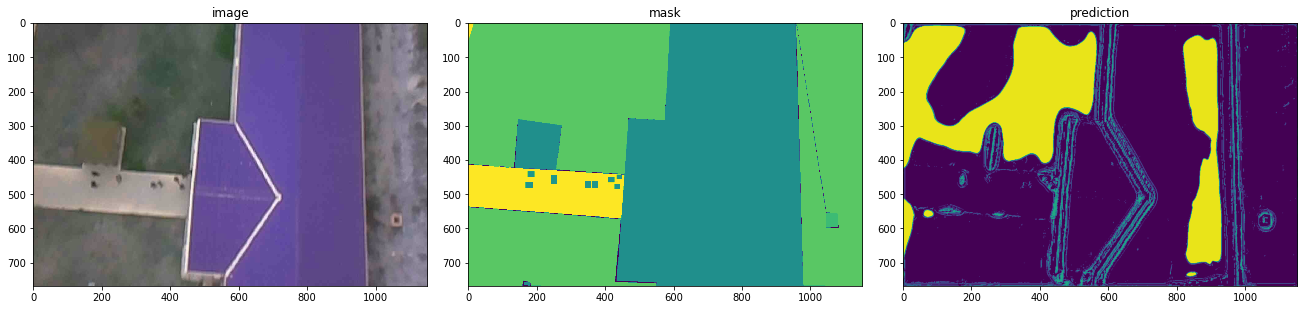

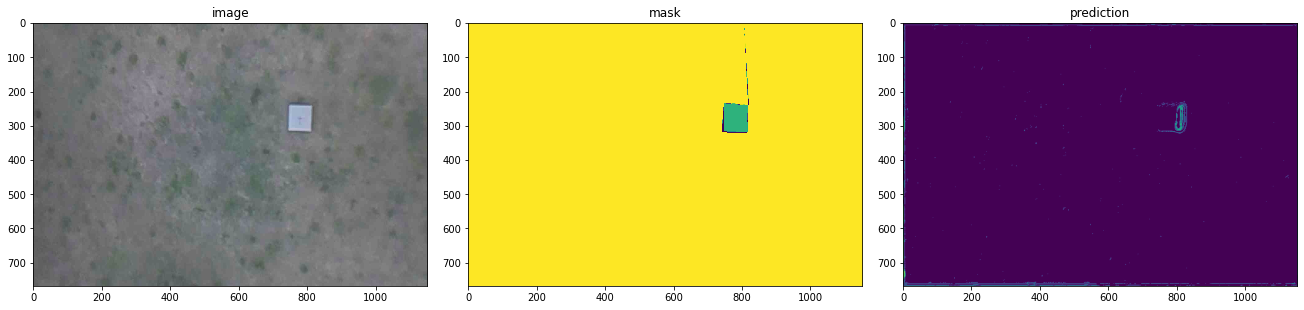

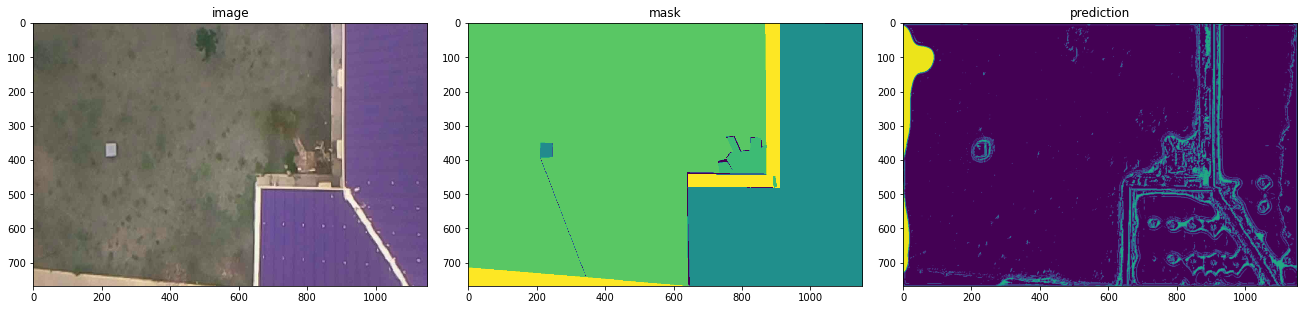

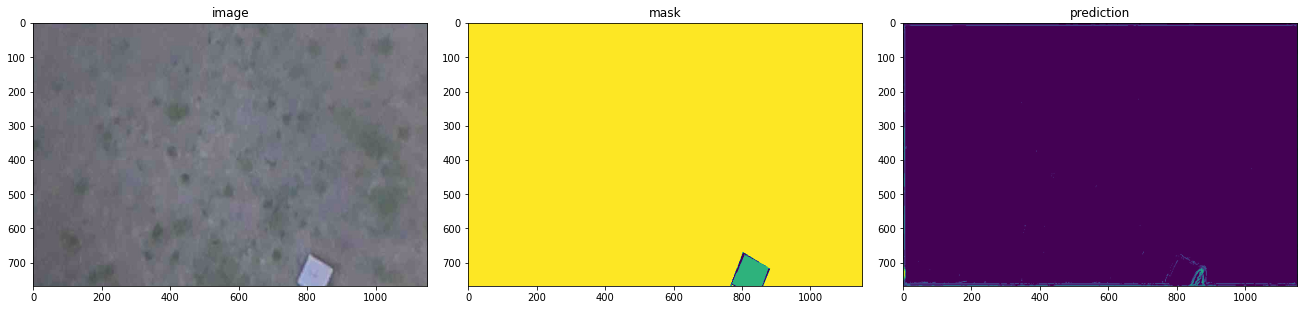

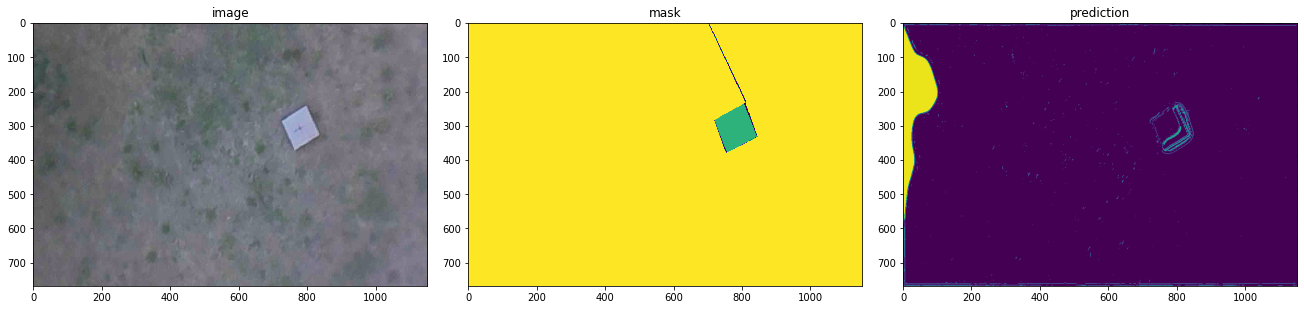

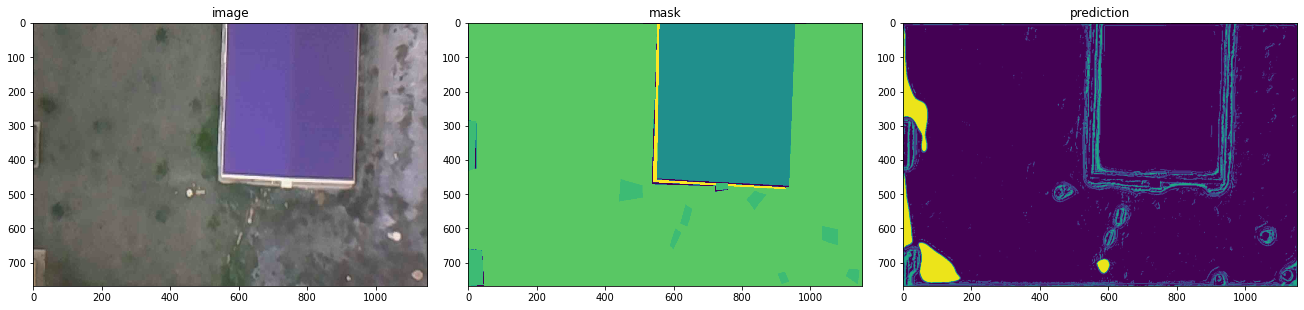

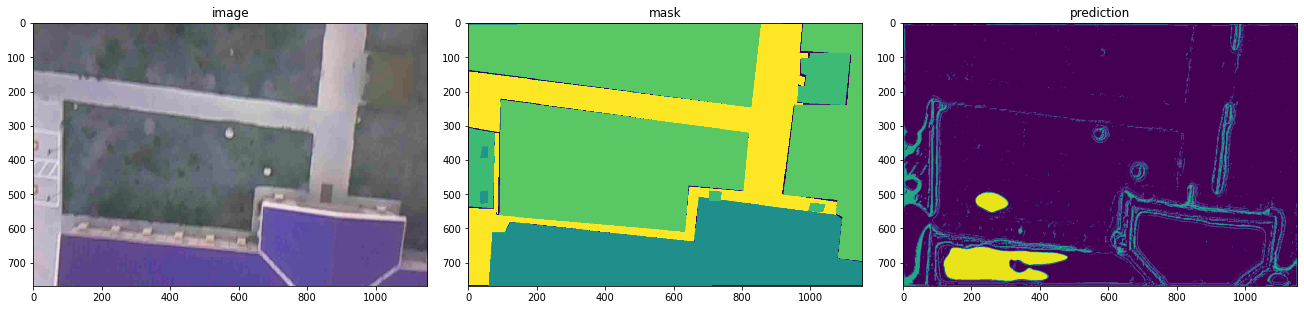

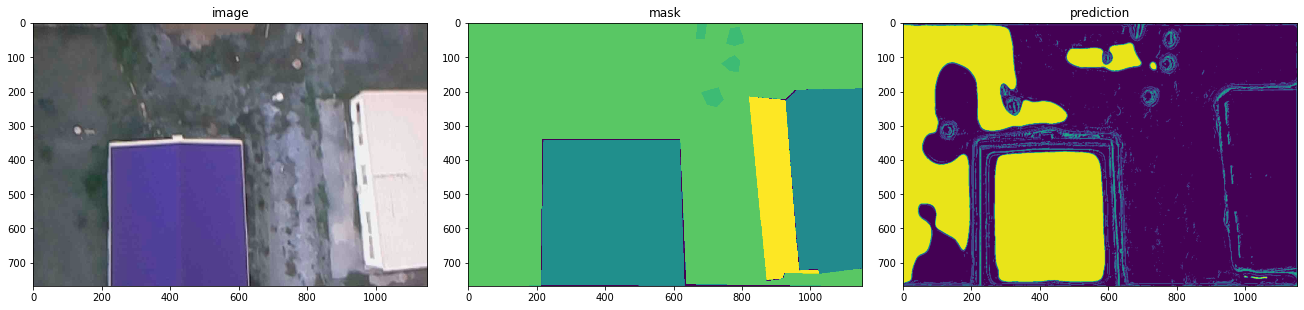

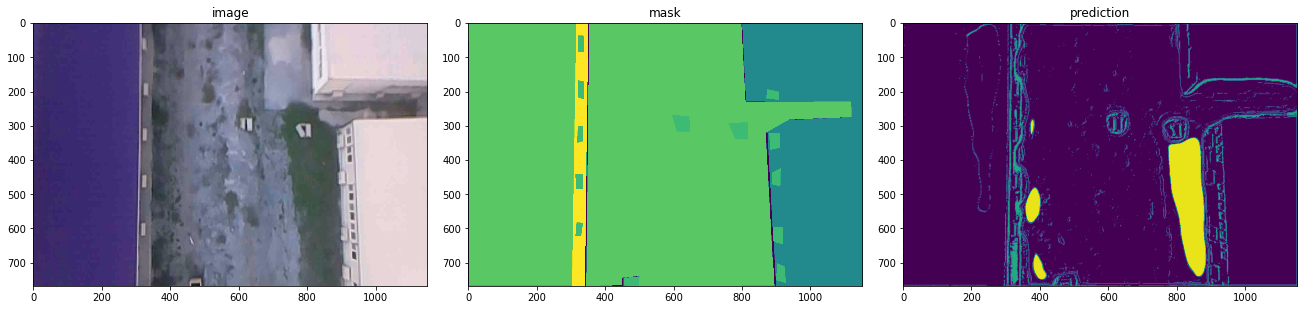

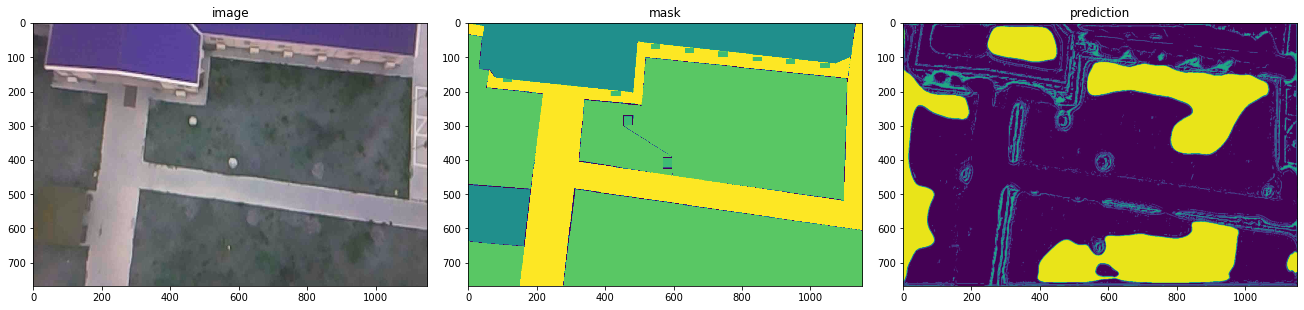

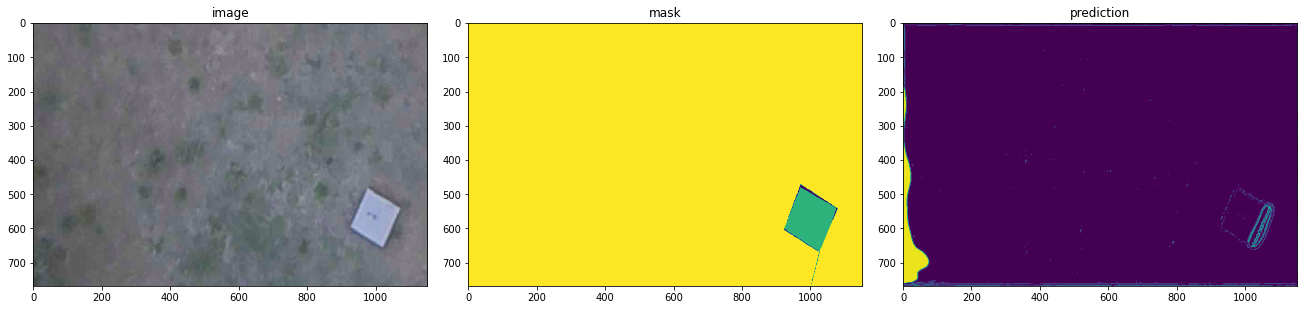

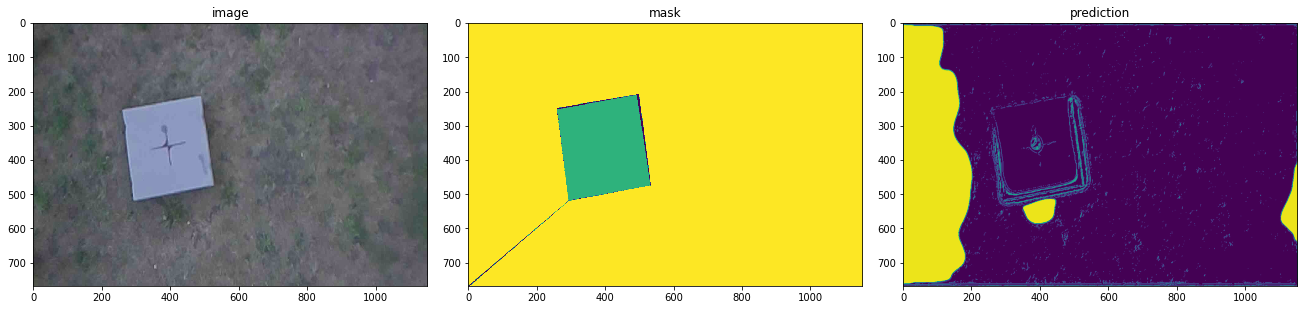

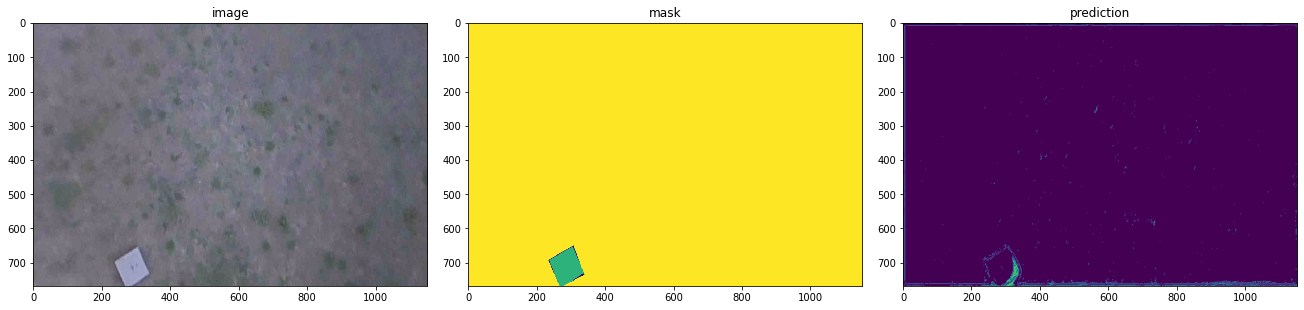

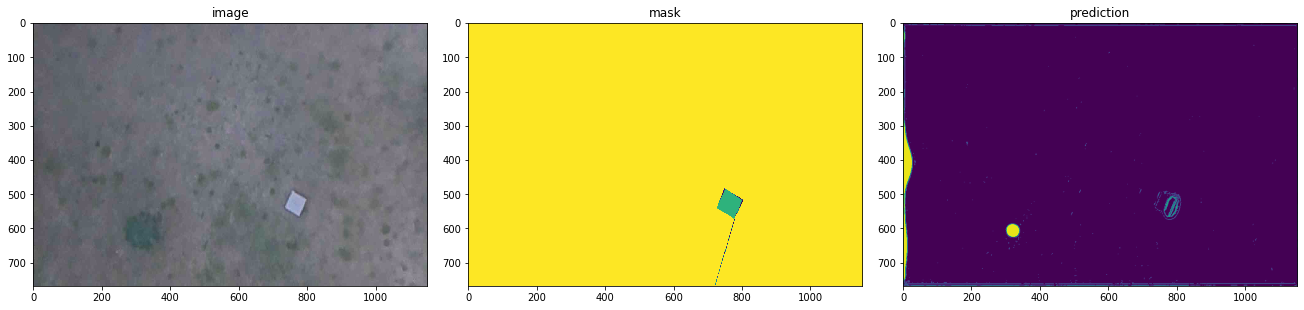

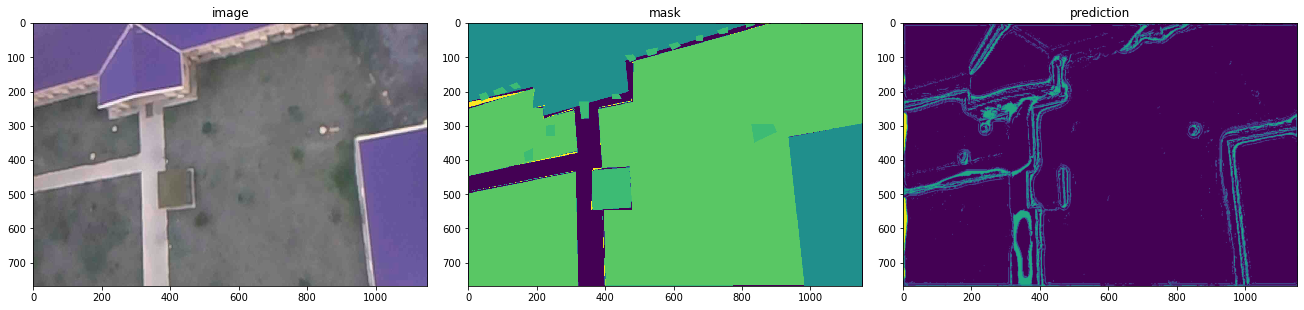

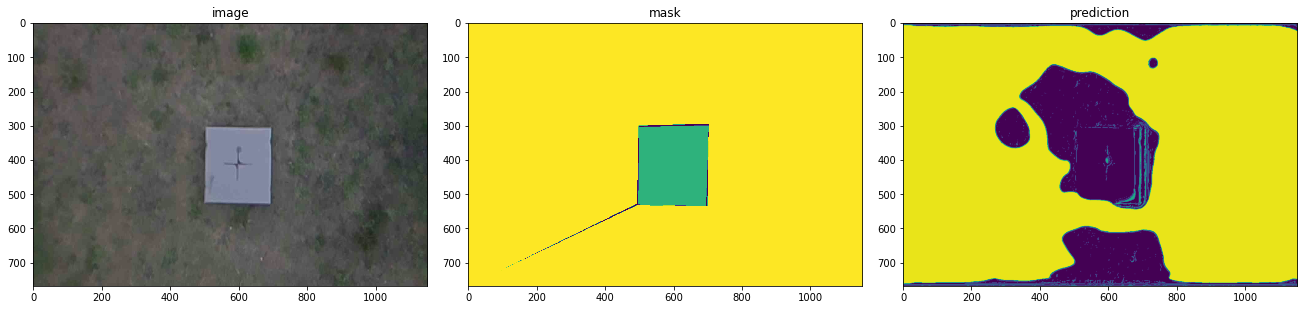

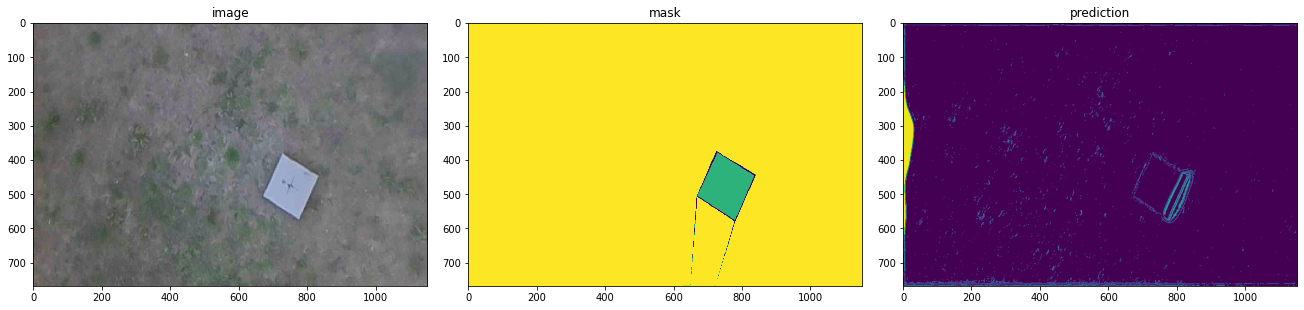

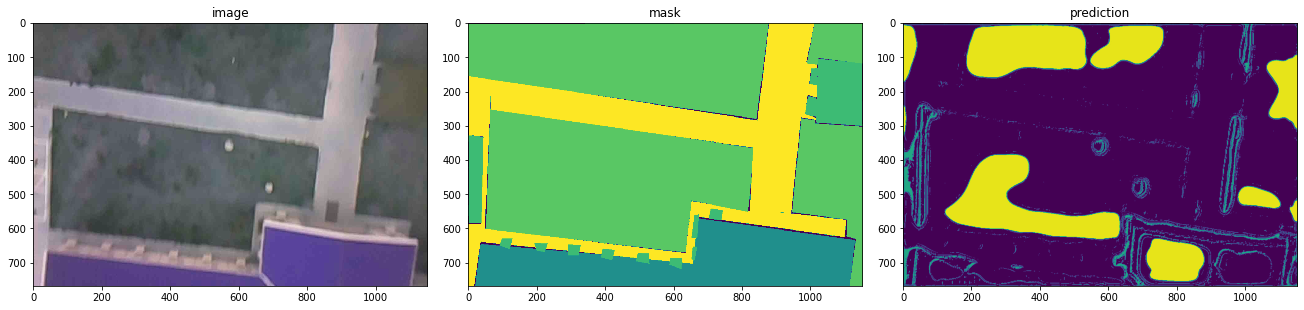

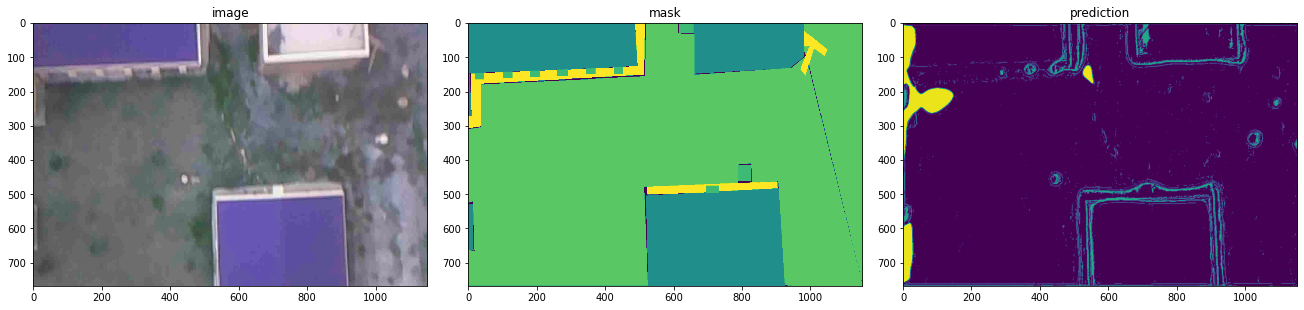

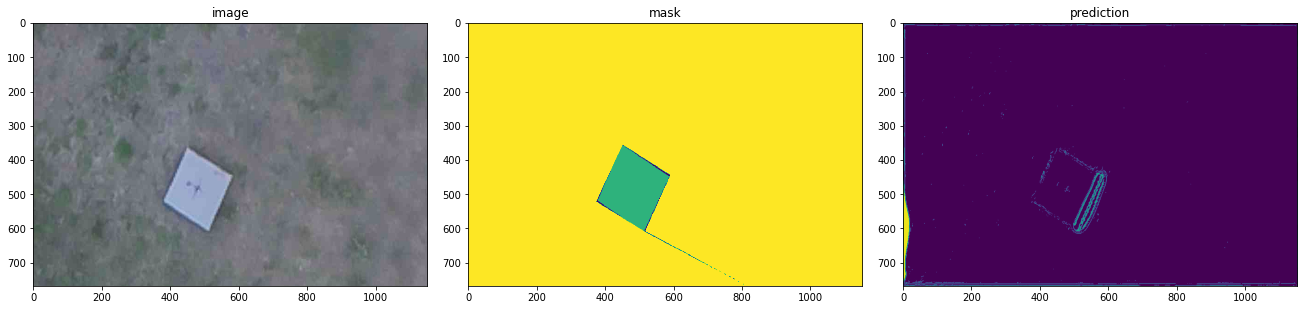

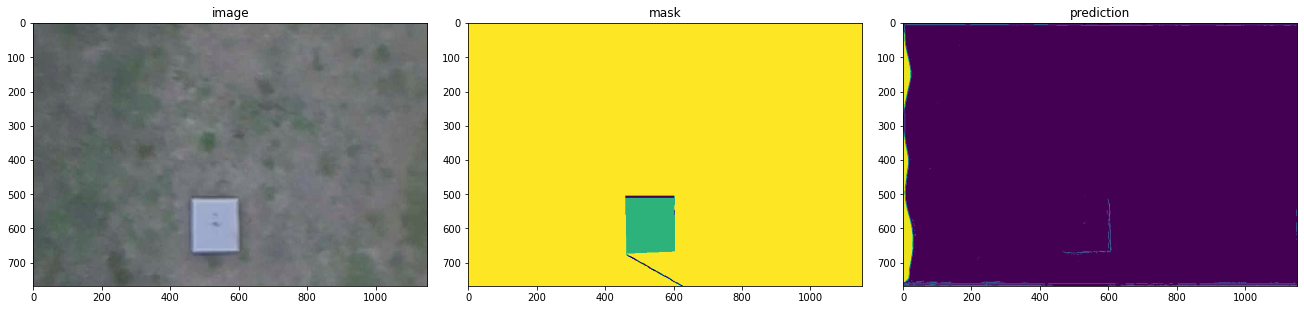

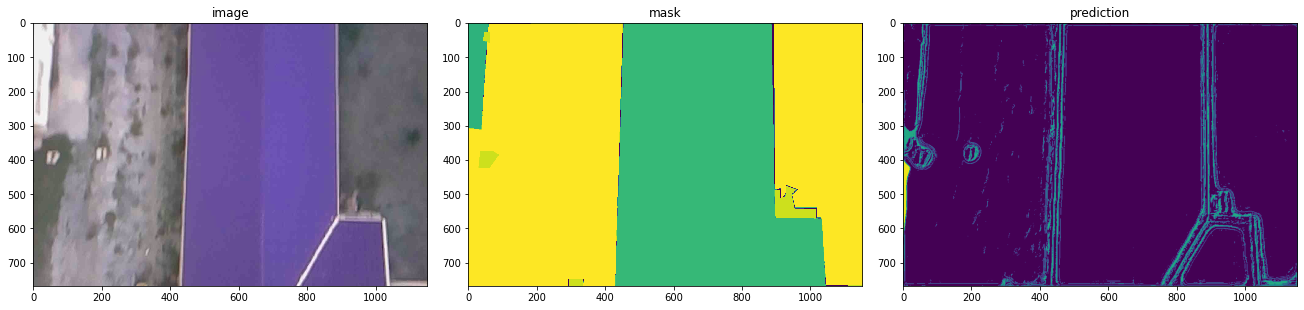

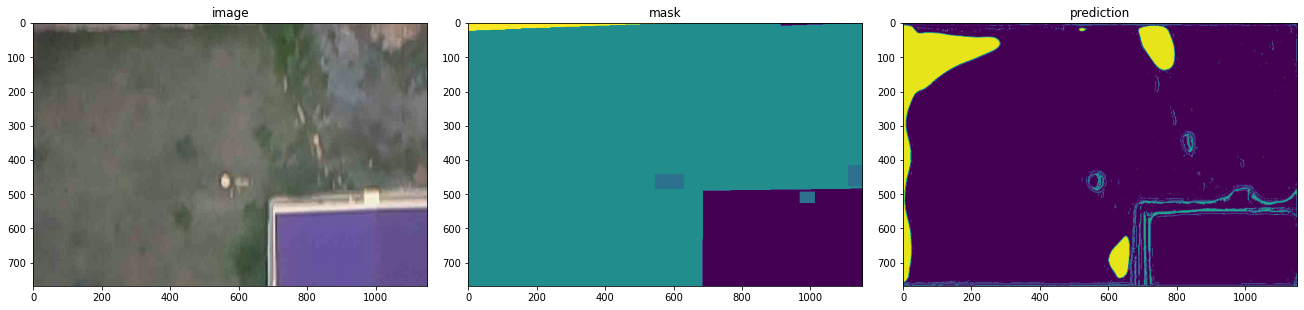

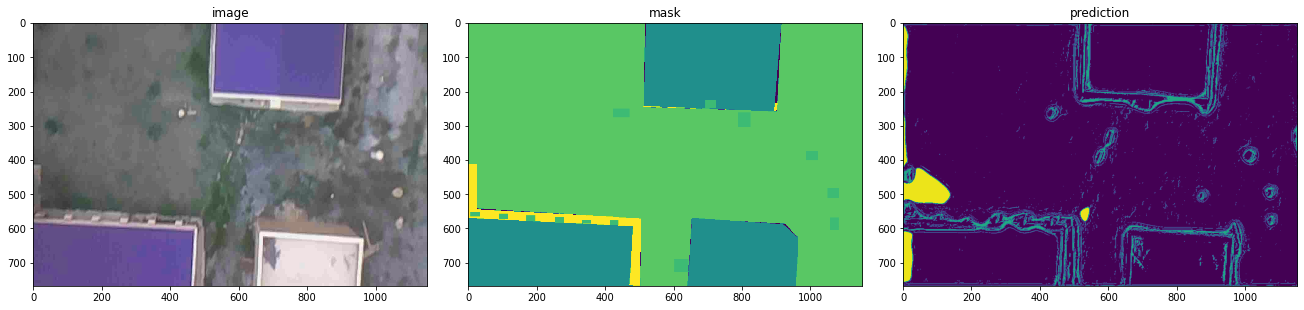

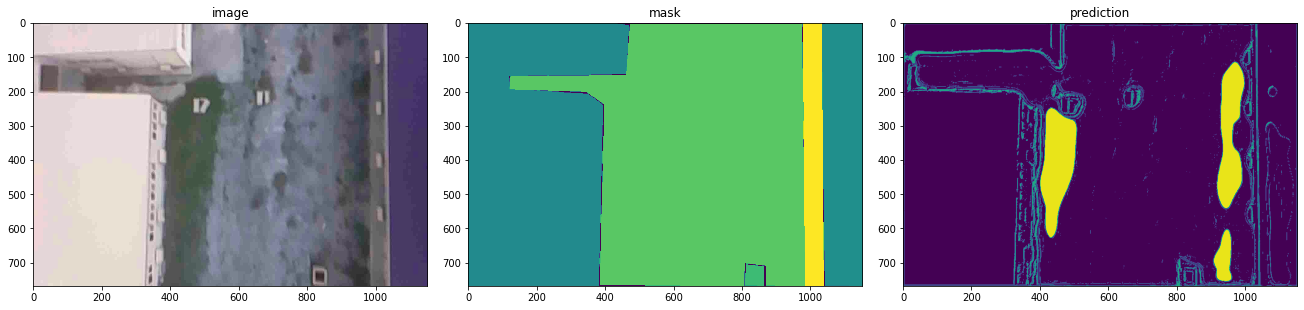

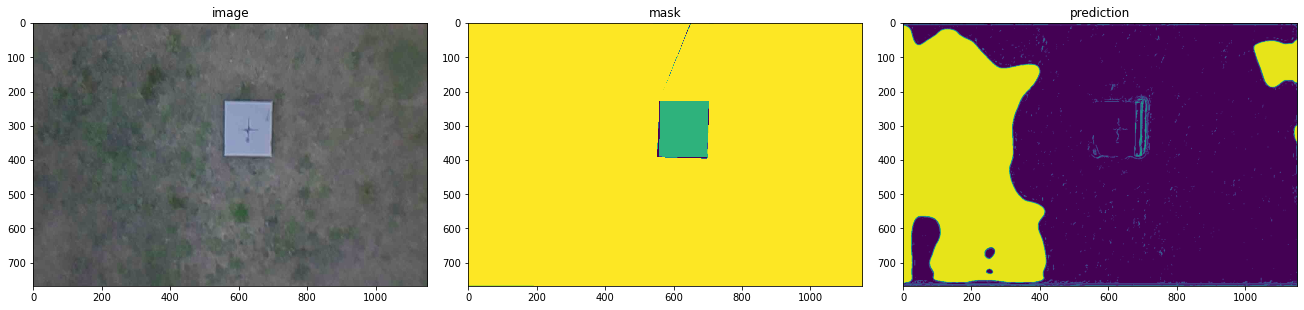

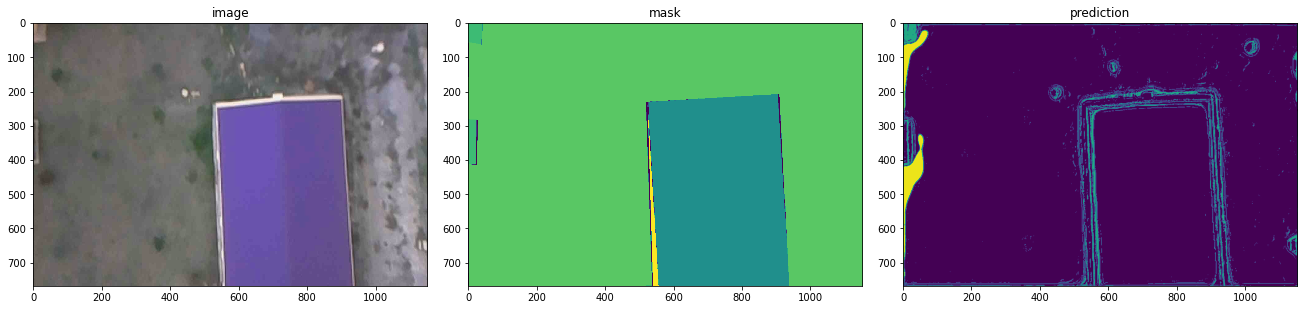

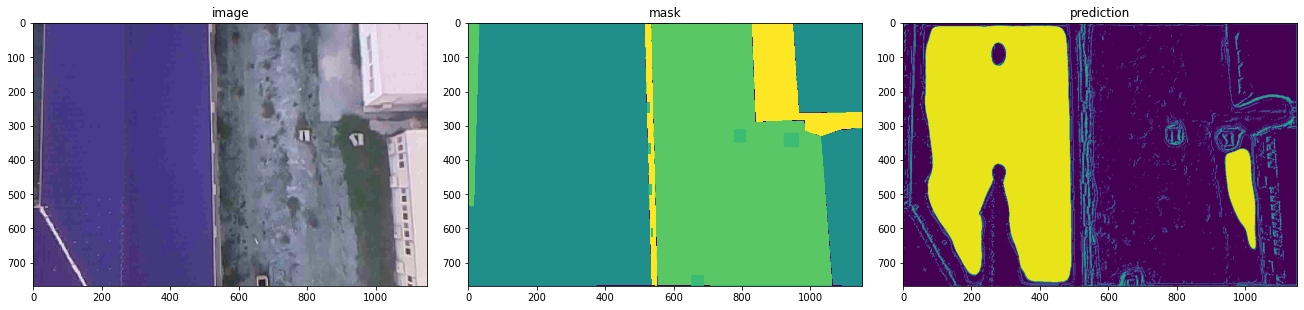

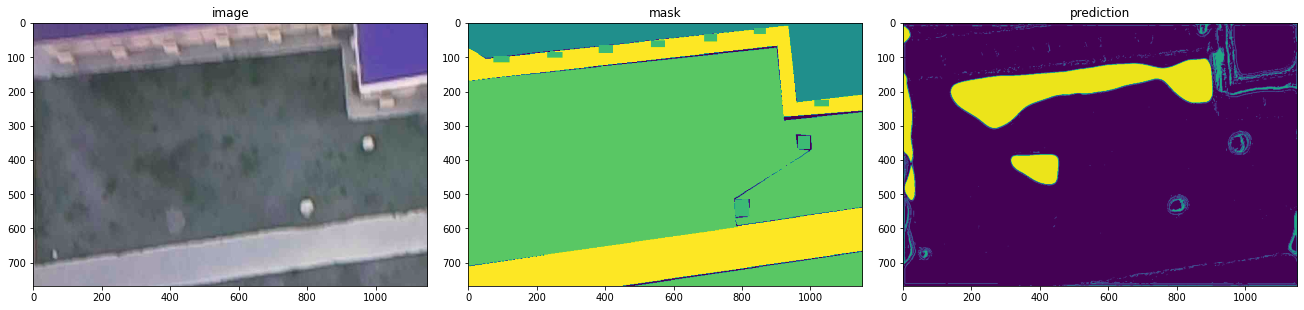

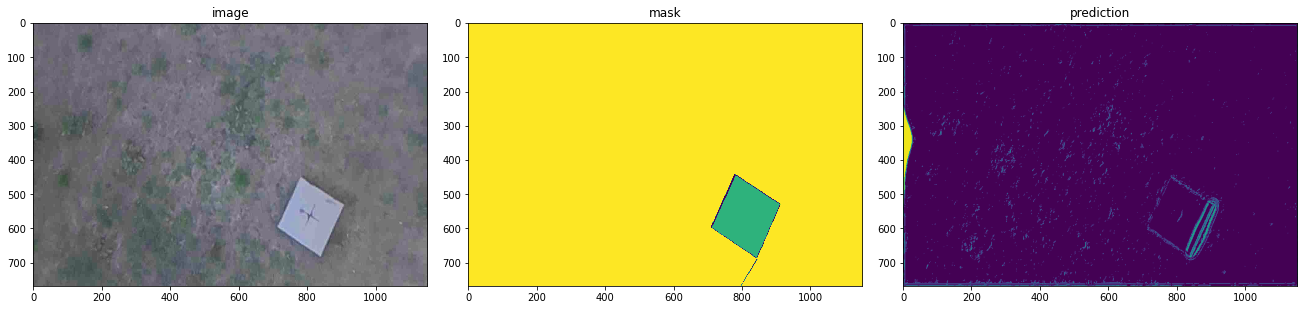

In [76]:
## Plot a few images to verify the accuracy in the predictions
save_path = '/content/result_images'

img_selection = image_list[0:30]
mask_selection = mask_list[0:30]
index = 0
for img, mask in zip(img_selection, mask_selection):
    result_images_path = os.path.join(save_path,str(index))
    os.makedirs(result_images_path)

    name = img.split("/")[-1]
    x = cv2.imread(img, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))

    y = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))

    p = cv2.imread(f"./results/{name}", cv2.IMREAD_GRAYSCALE)
    p = cv2.resize(p, (W, H))

    #Plot the image
    fig, axs = plt.subplots(1, 3, figsize=(18, 12), constrained_layout=True)
    
    axs[0].imshow(x, interpolation = 'nearest')
    axs[0].set_title('image')
    axs[0].grid(False)
    tmp_msk_name = f"image_{index}.jpg"  
    image_path = os.path.join(result_images_path, tmp_msk_name)
    cv2.imwrite(image_path,x)


    axs[1].imshow(y, interpolation = 'nearest')
    axs[1].set_title('mask')
    axs[1].grid(False)
    tmp_msk_name = f"mask_{index}.png"  
    image_path = os.path.join(result_images_path, tmp_msk_name)
    cv2.imwrite(image_path,y)

    axs[2].imshow(p)
    axs[2].set_title('prediction')
    axs[2].grid(False)
    tmp_msk_name = f"prediction_{index}.png"  
    image_path = os.path.join(result_images_path, tmp_msk_name)
    cv2.imwrite(image_path,p)

    index = index + 1
